In [1]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [2]:
scale = 4.1
bias = -13

# Random data
data = np.random.normal(0.7, 2.3, [1000])

# Normalize data
normalized_data = (data - np.mean(data)) / np.std(data)

data.shape, np.mean(data), np.std(data)

((1000,), 0.5925166510395966, 2.2965173294272496)

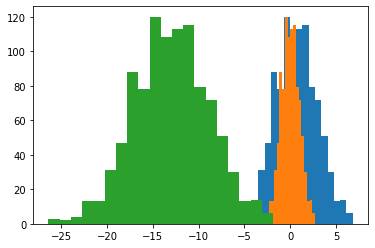

In [3]:
# Scale and bias data
new_data = (normalized_data * scale) + bias


# Plot data 
plt.hist(data, bins= 20)

plt.hist(normalized_data, bins = 20)

plt.hist(new_data, bins=20)

plt.show()

In [ ]:
# Fully-connected layer.

def dense_layer(x, fmaps, gain=1, use_wscale=True, lrmul=1, weight_var='weight'):
    if len(x.shape) > 2:
        x = tf.reshape(x, [-1, np.prod([d.value for d in x.shape[1:]])])
    # 定义一个权重张量w
    w = get_weight([x.shape[1].value, fmaps], gain=gain, use_wscale=use_wscale, lrmul=lrmul, weight_var=weight_var)
    w = tf.cast(w, x.dtype)
    return tf.matmul(x, w)  # 输入x与权重张量w，矩阵相乘

......

# Modulated convolution layer.

def modulated_conv2d_layer(x, y, fmaps, kernel, up=False, down=False, demodulate=True, resample_kernel=None, 
                           gain=1, use_wscale=True, lrmul=1, fused_modconv=True, weight_var='weight', 
                           mod_weight_var='mod_weight', mod_bias_var='mod_bias'):
    assert not (up and down)
    assert kernel >= 1 and kernel % 2 == 1

    # Get weight.
    # 定义权重w
    w = get_weight([kernel, kernel, x.shape[1].value, fmaps], gain=gain, use_wscale=use_wscale, 
                   lrmul=lrmul, weight_var=weight_var)
    ww = w[np.newaxis] # [BkkIO] Introduce minibatch dimension.

    # Modulate.
    s = dense_layer(y, fmaps=x.shape[1].value, weight_var=mod_weight_var) # [BI] Transform incoming W to style.
    s = apply_bias_act(s, bias_var=mod_bias_var) + 1 # [BI] Add bias (initially 1).
    ww *= tf.cast(s[:, np.newaxis, np.newaxis, :, np.newaxis], w.dtype) # [BkkIO] Scale input feature maps.

    # Demodulate.
    if demodulate:
        d = tf.rsqrt(tf.reduce_sum(tf.square(ww), axis=[1,2,3]) + 1e-8) # [BO] Scaling factor.
        ww *= d[:, np.newaxis, np.newaxis, np.newaxis, :] # [BkkIO] Scale output feature maps.